In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

---

## Propagation Functions

In [4]:
def prop_MFT_prim(wavefront, sign, nlamDX, nlamDY, offsetX, offsetY, npupX, npupY, npixX, npixY):
    """
    Base level function that performs the MFT from one plane to another
    
    Params (non-static)
        Wavefront (complex ndarray): Input wavefront to the MFT  
        nlamDX (float): Number of fringes in X, determined by wavelength and sampling rates
        nlamDY (float): Number of fringes in Y, determined by wavelength and sampling rates
        offsetX (float): Offset of the zeroth frequency
        offestY (float): Offset of the zeroth frequency
        sign (+1 or -1): Determines if it is a pupil -> focal (+1) or focal -> pupil plane (-1)
    Params (static)
        npupX (int): Number of pixels in the X direction in the initial plane
        npupY (int): Number of pixels in the Y direction in the initial plane
        npixX (int): Number of pixels in the X direction in the final plane
        npixY (int): Number of pixels in the Y direction in the final plane
    These static parameters form a hash key for the jitted version of this fucntion
    
    Returns:
        final_wavefront
    """
    dU = nlamDX / float(npixX)
    dV = nlamDY / float(npixY)
    dX = 1.0 / float(npupX)
    dY = 1.0 / float(npupY)

    Xs = (np.arange(npupX, dtype=float) - float(npupX) / 2.0 - offsetX + 0.5) * dX
    Ys = (np.arange(npupY, dtype=float) - float(npupY) / 2.0 - offsetY + 0.5) * dY
    Us = (np.arange(npixX, dtype=float) - float(npixX) / 2.0 - offsetX + 0.5) * dU
    Vs = (np.arange(npixY, dtype=float) - float(npixY) / 2.0 - offsetY + 0.5) * dV
        
    XU = np.outer(Xs, Us)
    YV = np.outer(Ys, Vs)
    
    expXU = np.exp(-2.0 * np.pi * sign * 1j * XU)
    expYV = np.exp(-2.0 * np.pi * sign * 1j * YV).T

    # Note: Can casue overflow issues on 32-bit
    norm_coeff = np.sqrt((nlamDY * nlamDX) / (npupY * npupX * npixY * npixX)) 

    # Perform MFT
    t1 = np.dot(expYV, wavefront)
    t2 = np.dot(t1, expXU)
    final_wavefront = norm_coeff * t2
    
    return final_wavefront

def fft_prop_prim(arr):
    norm = arr.shape[0] # Match poppy
    TF_arr = np.fft.fftshift( np.fft.ifft2(arr) )
    array_out = TF_arr * norm
    return array_out    

def ifft_prop_prim(arr):
    norm = 1./arr.shape[0] # Match poppy
    TF_arr = np.fft.fft2(np.fft.ifftshift(arr))
    array_out = TF_arr * norm
    return array_out

---

## Array Operation Functions

In [5]:
def pad_to_oversample(array, oversample):
    """ Add zeros around the edge of an array, for a given desired FFT integer oversampling ratio

    Parameters
    ----------
    array :  ndarray
        A 2D array representing some image
    oversample : int
        Padding factor for expanding the array

    Returns
    -------
    padded_array : ndarray
        A larger array containing mostly zeros but with the input array in the center.

    See Also
    ---------
    padToSize
    """
    npix = array.shape[0]
    padded = np.zeros(shape=(npix * oversample, npix * oversample), dtype=array.dtype)
    n0 = float(npix) * (oversample - 1) / 2
    n1 = n0 + npix
    n0 = int(round(n0))  # because astropy test_plugins enforces integer indices
    n1 = int(round(n1))
    padded = padded.at[n0:n1, n0:n1].set(array)
    return padded

def remove_padding(array, oversample):
    """ Remove zeros around the edge of an array, assuming some integer oversampling padding factor """
    npix = array.shape[0] / oversample
    n0 = float(npix) * (oversample - 1) / 2
    n1 = n0 + npix
    n0 = int(round(n0))
    n1 = int(round(n1))
    return array[n0:n1, n0:n1].copy()

---

## Other Functions

In [6]:
def normalise_wf(wavefront):
    norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
    norm_wavefront = wavefront/norm_factor
    return norm_wavefront

def opd_to_phase(opd, wavel):
    return 2*pi*opd/wavel

---

## Poppy Compile Functions

In [7]:
def get_osys_properties(osys, wavels):
    """
    Takes in the poppy osyses and the wavelengths we care about and returns the properties 
    
    # Old docstring
    Takes in the poppy intermediate wavefront list and extracts the information we need
    Note we dont calcuate nlamD here becuase this depends on wavelength
    
    Not all the returned information is usefull but this provides a more robust
    way to get all the information 
    """
    # Define this here becuase we dont give a fuck about it anywhere else
    planetype_dict = {
        poppy.poppy_core.PlaneType.pupil: 1,
        poppy.poppy_core.PlaneType.image: 2,
        poppy.poppy_core.PlaneType.detector: 3,
        poppy.poppy_core.PlaneType.rotation: 4,
        poppy.poppy_core.PlaneType.intermediate: 5
    }

    # Get Optics/Phasors (which are assumed to be wavelength dependent since they sometimes are)
    planes = osys.planes
    nplanes = len(planes)

    # Get plane types for both MFT sign convention and FFT/MFT determination
    planetypes = []
    for plane in planes:
        # planetype = planetype_dict[wf_obj.planetype] # Conver this value into an integer later for more complex systems
        planetype = planetype_dict[plane.planetype] # Conver this value into an integer later for more complex systems
        planetypes.append(planetype)
    planetypes = np.array(planetypes)

    # Get Propagation signs and Propagation Types
    signs = []
    proptypes = []
    for i in range(nplanes-1):
        if planetypes[i] == 1 and planetypes[i+1] == 2:
            proptypes.append("FFT")
            signs.append(+1)
        elif planetypes[i] == 2 and planetypes[i+1] == 1:
            proptypes.append("FFT")
            signs.append(-1)
        elif planetypes[i] == 1 and planetypes[i+1] == 3:
            proptypes.append("MFT")
            signs.append(+1)
        else:
            raise NotImplementedError("Propagating from planetype {} to {} is not yet implemented"
                                      .format(planetypes[i], planetypes[i+1]))
    signs = np.array(signs)
    

    intermediate_wavefronts = []
    optics = []
    for wavel in tqdm(wavels):
        fits_out, intermediate_wfs = osys.calc_psf(wavel, return_intermediates=True)
        intermediate_wavefronts.append(intermediate_wfs)

        # Get Paddings and oversamplings
        is_padded, oversampling = [], [] # Just overwrite these values
        for i in range(len(intermediate_wfs)):
            is_padded.append(intermediate_wfs[i].ispadded)
            oversampling.append(intermediate_wfs[i].oversample)

        optics_temp, depad = [], []
        shapes = [] # Just redefine and overwrite this becuase it doesnt change over the loops
        for i in range(nplanes - 1): # Dont get phasor from detector because it has none
            plane1, plane2 = planes[i], planes[i+1]
            wf1, wf2 = intermediate_wfs[i], intermediate_wfs[i+1]
            
            # Check for de-padding
            if intermediate_wfs[i].ispadded and not intermediate_wfs[i+1].ispadded:
                depad.append(True)
            else:
                depad.append(False)

            # Check for padding and get padded shape sizes
            if proptypes[i] == "FFT" and wf1.shape[0] != wf2.shape[0]:
                pad_factor = np.array(wf2.shape[0]) // np.array(wf1.shape[0])
                wf_shape = wf2.shape
            else:
                pad_factor = 1
                wf_shape = wf1.shape
            shapes.append(wf_shape)

            # Get optic
            if hasattr(plane1, 'get_phasor'):
                phasor = plane1.get_phasor(wf1)
            else:
                wf_shape = wf1.wavefront.shape
                phasor = np.ones(wf_shape) * np.exp(1j*np.zeros(wf_shape))
                
            # Pad by deafult becuase lazy
            phasor = pad_to_oversample(phasor, pad_factor)
            optics_temp.append(phasor)

        optics.append(optics_temp)
    # optics = np.array(optics) # Cant array becuase shapes are different
    shapes = np.array(shapes)
    
    
    # Take sample wavefronts for wavelength agnostic values
    sample_wf_list = intermediate_wavefronts[0]
    



    # Get MFT properties (wavelength agnostic properties)
    # shapes, diams, pixelscales, fovs = [], [], [], []
    diams, pixelscales, fovs = [], [], []
    # This should be wavelength independent so dont loop on wavels
    for wf_obj in sample_wf_list:
        # Get Diam
        diam = wf_obj.diam.to(u.m).value
        diams.append(diam)
        
        # Get pixelscales (Assumes pupil or image or detector inputs)
        if wf_obj.planetype is poppy.poppy_core.PlaneType.pupil:
            pixelscale = wf_obj.pixelscale.to(u.m/u.pix).value
        else: 
            pixelscale = wf_obj.pixelscale.to(u.radian/u.pix).value
            
        # Get FoV
        shape = wf_obj.shape
        fov = [shape[0]*pixelscale, shape[1]*pixelscale]
        pixelscales.append(pixelscale)
        fovs.append(fov)

    diams = np.array(diams)
    pixelscales = np.array(pixelscales)
    fovs = np.array(fovs)


    wavels = np.array(wavels) # Ensure wavels is ndarray for vector operation
    # Get nlamDs for MFTs
    # Note this IS wavelengths dependent but we can do this with vectors
    npups, npixs, nlamDs = [], [], []
    for i in range(nplanes - 1):
        
        npups.append(shapes[i])
        if planetypes[i+1] == 3: # If we are propping to a detector (which should always be the case for MFT)
            plane = planes[i+1] # i+1 becuase thats what were propping to
            npix = plane.fov_pixels.to(u.pixel).value * plane.oversample
            npixs.append([npix, npix])
            # print("Did this")
        else:
            npixs.append(shapes[i+1])

        nlamDX = (fovs[i+1][0] * diams[i])/wavels # Wavel vector done here
        nlamDY = (fovs[i+1][1] * diams[i])/wavels # Wavel vector done here
        nlamDs.append([nlamDX, nlamDY])
    npups = np.array(npups)
    npixs = np.array(npixs)
    nlamDs = np.array(nlamDs)

    # Assume zero offsets here becuase fuck this is niche
    offsets = np.zeros([nplanes, 2])

    return optics, planetypes, shapes, signs, proptypes, npups, npixs, nlamDs, offsets, depad, oversampling

---
## Padding and intermediate plane operations

Since we will have to create intermediate array operations for invertion and rotations planes, we need to also do this for padding and un-padding as it is an intermediary array operation done within a single plane, so we will have to create the infractructure for this too!

---

## Osys number 1

In [8]:
min_wavel = 5e-6
max_wavel = 6e-6
nwavels = 6

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [9]:
osys = poppy.OpticalSystem(pupil_diameter=3*u.meter)
osys.add_pupil(poppy.CircularAperture(radius=0.5*u.meter))    
osys.add_image(poppy.RectangularFieldStop(width=0.5*u.arcsec, height=10*u.arcsec) )
osys.add_pupil(poppy.CircularAperture(radius=1*u.meter))   # reimaged pupil in spectrograph; typically would have a grating here  
osys.add_detector(pixelscale=0.010*u.arcsec/u.pixel, fov_arcsec=5.0)  

wavel = wavels[0]
fits_out, intermediate_wfs = osys.calc_psf(wavel, return_intermediates=True)
wf_obj = intermediate_wfs[-1]
hist = wf_obj.history
for j in range(len(hist)):
    print(hist[j])
print('\n')

Created wavefront: wavelength=5e-06 m, diam=3 m
 using array size (1024, 1024)
  Multiplied WF by phasor for Pupil plane: Circle, radius=0.5 m
  Propagating wavefront to Image plane: unnamed field stop. 
    Padded WF array for oversampling by 2x
   FFT (2048, 2048),  to IMAGE plane  scale=0.1719 arcsec / pix
  Multiplied WF by phasor for Image plane: unnamed field stop
  Propagating wavefront to Pupil plane: Circle, radius=1.0 m. 
   FFT (2048, 2048),  to PUPIL scale=0.0029 m / pix
  Multiplied WF by phasor for Pupil plane: Circle, radius=1.0 m
  Propagating wavefront to Detector plane: Detector (500x500 pixels, 0.010 arcsec / pix). 
    Propagating w/ MFT: 0.0050 arcsec / pix     fov=14.544 lam/D    npix=1000
Multiplied WF by scalar value 1.0




In [10]:
properties = get_osys_properties(osys, wavels)
optics, planetypes, shapes, signs, proptypes, npups, npixs, nlamDs, offsets, depad, oversampling = properties

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
nprops = len(signs)

poppy_psfs_out = []
poppy_intermediate_wfs = []


morph_psfs_out = []
morph_intermediate_wfs = []

poppy_times = []
morph_times = []

for i in range(nwavels):
    print("\nWavel: {}".format(wavels[i]))
    
    
    # Do Poppy
    t0 = t.time()
    fits_out, intermediate_wfs = osys.calc_psf(wavels[i], return_intermediates=True)
    t1 = t.time()
    poppy_times.append(t1-t0)
    
    poppy_intermediate_wfs.append(intermediate_wfs)
    poppy_psfs_out.append(fits_out[0].data)
    
    # Do Morphine
    intermed_wfs = []
    
    t0 = t.time()
    wavefront = np.ones(optics[i][0].shape) * np.exp(1j*np.zeros(optics[i][0].shape))
    for j in range(nprops):
        sign = signs[j]
        wavefront *= optics[i][j]
        
        # Assume aperture normalisation
        if j == 0:
            wavefront = normalise_wf(wavefront)
        
        intermed_wfs.append(wavefront)

        if proptypes[j] == "FFT":
            if signs[j] == 1:
                wavefront = fft_prop_prim(wavefront)
                print("Propped FFT  ", end='')
            else:
                wavefront = ifft_prop_prim(wavefront)
                print("Propped IFFT  ", end='')

        elif proptypes[j] == "MFT":
            npupX, npupY = npups[j]
            nlamDX, nlamDY = nlamDs[j, :, i]            
            offsetX, offsetY = offsets[j]
            npixX, npixY = npixs[j]

            # Check for de-padding
            # Do this properly later with an array operation propagation
            if depad[j]:
                k = oversampling[j+1]
                c = wavefront.shape[0]//2
                s = c//k
                wavefront = wavefront[c-s:c+s, c-s:c+s]
                npupX = npupX//k
                npupY = npupY//k

            wavefront = prop_MFT_prim(wavefront, sign,
                                       nlamDX, nlamDY, 
                                       offsetX, offsetY, 
                                       float(npupX), float(npupY), 
                                       float(npixX), float(npixY))

            print("Propped MFT  ", end='')
        else:
            print("This shouldnt happen - Somethings gone wrong eh")
            
            
    morph_psfs_out.append(np.abs(wavefront)**2)
    intermed_wfs.append(wavefront)
    
    morph_intermediate_wfs.append(intermed_wfs)
    
    t1 = t.time()
    morph_times.append(t1-t0)
    
    # wavefronts_out.append(wavefront)
poppy_psfs_out = np.array(poppy_psfs_out)
morph_psfs_out = np.array(morph_psfs_out)

# Times
poppy_times = np.array(poppy_times)
morph_times = np.array(morph_times)
print("\n\nMean Poppy calculation time: {:.4f}s".format(np.mean(poppy_times)))
print("Mean Morph calculation time: {:.4f}s".format(np.mean(morph_times)))


Wavel: 5e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.200000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.400000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.600000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.8e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 6e-06
Propped FFT  Propped IFFT  Propped MFT  

Mean Poppy calculation time: 0.8623s
Mean Morph calculation time: 0.2894s


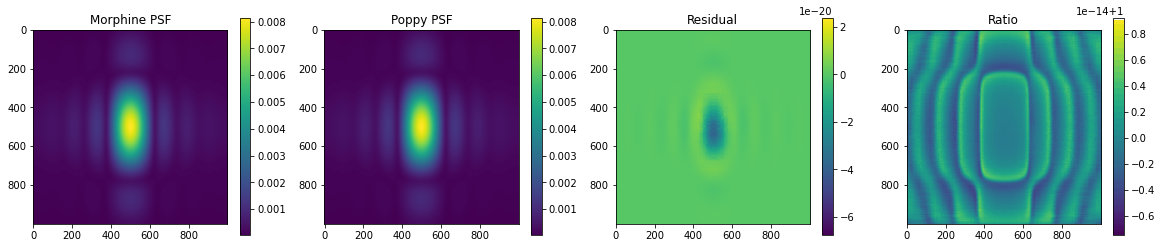

In [16]:
flux = 1.

poppy_psf = flux*np.sum(poppy_psfs_out, axis=0)
morph_psf = flux*np.sum(morph_psfs_out, axis=0)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(morph_psf**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - morph_psf)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/morph_psf)
# plt.imshow(np.log10(poppy_psf/morph_psf))
plt.title("Ratio")
plt.colorbar()
plt.show()

In [17]:
result = bool(np.allclose(poppy_psf, morph_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(poppy_psf, morph_psf))
    plt.colorbar()
    plt.show()

Yee Haaw!


---

## Osys number 2

In [18]:
radius = 6.5/2
lyot_radius = 6.5/2.5
pixelscale = 0.060

osys = poppy.OpticalSystem("test", oversample=8)
osys.add_pupil( poppy.CircularAperture(radius=radius), name='Entrance Pupil')
osys.add_image( poppy.CircularOcculter(radius = 0.1) )
osys.add_pupil( poppy.CircularAperture(radius=lyot_radius), name='Lyot Pupil')
osys.add_detector(pixelscale=pixelscale, fov_arcsec=5.0)

wavel = wavels[0]
fits_out, intermediate_wfs = osys.calc_psf(wavel, return_intermediates=True)
wf_obj = intermediate_wfs[-1]
hist = wf_obj.history
for j in range(len(hist)):
    print(hist[j])
print('\n')

Created wavefront: wavelength=5e-06 m, diam=6.5 m
 using array size (1024, 1024)
  Multiplied WF by phasor for Pupil plane: Circle, radius=3.25 m
  Propagating wavefront to Image plane: unnamed occulter. 
    Padded WF array for oversampling by 8x
   FFT (8192, 8192),  to IMAGE plane  scale=0.0198 arcsec / pix
  Multiplied WF by phasor for Image plane: unnamed occulter
  Propagating wavefront to Pupil plane: Circle, radius=2.6 m. 
   FFT (8192, 8192),  to PUPIL scale=0.0063 m / pix
  Multiplied WF by phasor for Pupil plane: Circle, radius=2.6 m
  Propagating wavefront to Detector plane: Detector (83x83 pixels, 0.060 arcsec / pix). 
    Propagating w/ MFT: 0.0075 arcsec / pix     fov=31.387 lam/D    npix=664
Multiplied WF by scalar value 1.0




In [20]:
properties = get_osys_properties(osys, wavels)
optics, planetypes, shapes, signs, proptypes, npups, npixs, nlamDs, offsets, depad, oversampling = properties

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
nprops = len(signs)

poppy_psfs_out = []
poppy_intermediate_wfs = []


morph_psfs_out = []
morph_intermediate_wfs = []

poppy_times = []
morph_times = []

for i in range(nwavels):
    print("\nWavel: {}".format(wavels[i]))
    
    
    # Do Poppy
    t0 = t.time()
    fits_out, intermediate_wfs = osys.calc_psf(wavels[i], return_intermediates=True)
    t1 = t.time()
    poppy_times.append(t1-t0)
    
    poppy_intermediate_wfs.append(intermediate_wfs)
    poppy_psfs_out.append(fits_out[0].data)
    
    # Do Morphine
    intermed_wfs = []
    
    t0 = t.time()
    wavefront = np.ones(optics[i][0].shape) * np.exp(1j*np.zeros(optics[i][0].shape))
    for j in range(nprops):
        sign = signs[j]
        wavefront *= optics[i][j]
        
        # Assume aperture normalisation
        if j == 0:
            wavefront = normalise_wf(wavefront)
        
        intermed_wfs.append(wavefront)

        if proptypes[j] == "FFT":
            if signs[j] == 1:
                wavefront = fft_prop_prim(wavefront)
                print("Propped FFT  ", end='')
            else:
                wavefront = ifft_prop_prim(wavefront)
                print("Propped IFFT  ", end='')

        elif proptypes[j] == "MFT":
            npupX, npupY = npups[j]
            nlamDX, nlamDY = nlamDs[j, :, i]            
            offsetX, offsetY = offsets[j]
            npixX, npixY = npixs[j]

            # Check for de-padding
            # Do this properly later with an array operation propagation
            if depad[j]:
                k = oversampling[j+1]
                c = wavefront.shape[0]//2
                s = c//k
                wavefront = wavefront[c-s:c+s, c-s:c+s]
                npupX = npupX//k
                npupY = npupY//k

            wavefront = prop_MFT_prim(wavefront, sign,
                                       nlamDX, nlamDY, 
                                       offsetX, offsetY, 
                                       float(npupX), float(npupY), 
                                       float(npixX), float(npixY))

            print("Propped MFT  ", end='')
        else:
            print("This shouldnt happen - Somethings gone wrong eh")
            
            
    morph_psfs_out.append(np.abs(wavefront)**2)
    intermed_wfs.append(wavefront)
    
    morph_intermediate_wfs.append(intermed_wfs)
    
    t1 = t.time()
    morph_times.append(t1-t0)
    
    # wavefronts_out.append(wavefront)
poppy_psfs_out = np.array(poppy_psfs_out)
morph_psfs_out = np.array(morph_psfs_out)

# Times
poppy_times = np.array(poppy_times)
morph_times = np.array(morph_times)
print("\n\nMean Poppy calculation time: {:.4f}s".format(np.mean(poppy_times)))
print("Mean Morph calculation time: {:.4f}s".format(np.mean(morph_times)))


Wavel: 5e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.200000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.400000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.600000000000001e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 5.8e-06
Propped FFT  Propped IFFT  Propped MFT  
Wavel: 6e-06
Propped FFT  Propped IFFT  Propped MFT  

Mean Poppy calculation time: 10.2065s
Mean Morph calculation time: 4.1535s


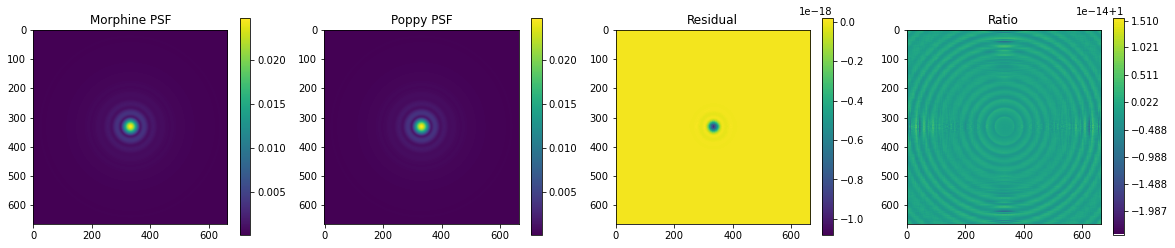

In [22]:
flux = 1.

poppy_psf = flux*np.sum(poppy_psfs_out, axis=0)
morph_psf = flux*np.sum(morph_psfs_out, axis=0)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(morph_psf**0.5)
plt.title("Morphine PSF")
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(poppy_psf**0.5)
plt.title("Poppy PSF")
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(poppy_psf - morph_psf)
plt.title("Residual")
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(poppy_psf/morph_psf)
# plt.imshow(np.log10(poppy_psf/morph_psf))
plt.title("Ratio")
plt.colorbar()
plt.show()

In [23]:
result = bool(np.allclose(poppy_psf, morph_psf))

if result is True:
    print("Yee Haaw!")
else:
    print("Better luck next time :'(")
    plt.imshow(np.isclose(poppy_psf, morph_psf))
    plt.colorbar()
    plt.show()

Yee Haaw!
